#  AIT 614 Final Project – Impact of Bridge Design Materials and Climate Exposure on Deterioration and Condition  (Team 6)


In [0]:
# 1: Install the necessary libraries
%pip install openpyxl plotly us
%pip install xgboost
%pip install imbalanced-learn

Python interpreter will be restarted.
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
  Using cached us-3.2.0-py3-none-any.whl (13 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
  Using cached jellyfish-1.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (357 kB)
Python interpreter will be restarted.
Python interpreter will be restarted.
  Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl (223.6 MB)
  Using cached nvidia_nccl_cu12-2.26.2.post1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (291.7 MB)
Python interpreter will be restarted.
Python interpreter will be restarted.
  Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)
Python interpreter will be restarted.


In [0]:
# 2: Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
# Assures that all matplotlib plots are displayed inline inside the notebook. This is helpful for exporting or presenting because it places visualizations directly beneath each cell.
%matplotlib inline

In [0]:
# 3: Load Excel File
file_path = "/dbfs/FileStore/selected_bridge_cleaned_dataset.csv"
dbutils.fs.cp("dbfs:/FileStore/tables/Selected_Bridges_Group6.xlsx", f"file:{file_path}")
dataframe_pd = pd.read_excel(file_path)
dataframe_pd.head()

Out[2]: '\ndf_spark = spark.read.csv("dbfs:/FileStore/tables/Selected_Bridges_Group6.csv", header=True, inferSchema=True)\ndataframe_pd = df_spark.toPandas()\ndataframe_pd.head()\n'

In [0]:
# 4: Rename the columns.
dataframe_pd.columns = dataframe_pd.columns.str.strip().str.lower().str.replace(' ', '_')
dataframe_pd.rename(columns={
    '1_-_state_code': 'state_code',
    '1_-_state_name': 'state_name',
    '8_-_structure_number': 'structure_number',
    '22_-_owner_agency': 'owner_agency',
    '43a_-_main_span_material': 'main_span_material',
    '43b_-_main_span_design': 'main_span_design',
    '107_-_deck_structure_type_code': 'deck_structure_type',
    '108a_-_wearing_surface_type_code': 'wearing_surface_type',
    '108b_-_membrane_type_code': 'membrane_type',
    '108c_-_deck_protection_code': 'deck_protection',
    '58_-_deck_condition_rating': 'deck_condition_rating',
    'number_of_snowfall_days': 'snowfall_days',
    'number_of_freeze-thaw_cycles': 'freeze_thaw_cycles',
    '27_-_year_built': 'year_built',
    '106_-_year_reconstructed': 'year_reconstructed'
}, inplace=True)
dataframe_pd.head()

,state_code,state_name,structure_number,owner_agency,main_span_material,main_span_design,deck_structure_type,wearing_surface_type,membrane_type,deck_protection,deck_condition_rating,snowfall_days,freeze_thaw_cycles,year_built,year_reconstructed
0,1,Alabama,012218,State Highway Agency,Concrete,Channel Beam,2.0,6.0,0.0,0.0,4.0,0,10,1979,0.0
1,1,Alabama,000529,State Highway Agency,Concrete,Tee Beam,1.0,6.0,0.0,0.0,4.0,1,33,1928,0.0
2,1,Alabama,007580,County Highway Agency,Concrete,Slab,1.0,1.0,0.0,8.0,5.0,2,25,1962,0.0
3,1,Alabama,005787,County Highway Agency,Concrete,Slab,1.0,1.0,0.0,0.0,8.0,0,9,1957,1993.0
4,1,Alabama,012021,City or Municipal Highway Agency,Concrete,Tee Beam,2.0,1.0,0.0,0.0,6.0,4,52,1978,0.0


In [0]:
# 5: Convert Column Data Types
# Convert deck_structure_type, wearing_surface_type, membrane_type, deck_protection from doubles to integer string
cols_to_convert = ["deck_structure_type", "wearing_surface_type", "membrane_type", "deck_protection"]

for col in cols_to_convert:
    dataframe_pd[col] = dataframe_pd[col].apply(lambda x: str(int(x)) if pd.notnull(x) else x)

In [0]:
# 6: Clean and Filter

from us import states

print(f"Before: {len(dataframe_pd)}")

# Validate U.S. State names
valid_states = {state.name for state in states.STATES}

# Only keep bridges that are in the States
dataframe_pd = dataframe_pd[dataframe_pd["state_name"].isin(valid_states)]

# Drop Duplicate bridges
dataframe_pd = dataframe_pd.drop_duplicates(subset='structure_number', keep='first')

print(f"After: {len(dataframe_pd)}")

Before: 125050
After: 123016


In [0]:
# 7: Fill Missing Values
num_cols = dataframe_pd.select_dtypes(include=['int64', 'float64']).columns
dataframe_pd[num_cols] = dataframe_pd[num_cols].fillna(dataframe_pd[num_cols].median())
cat_cols = dataframe_pd.select_dtypes(include=['object']).columns
dataframe_pd[cat_cols] = dataframe_pd[cat_cols].fillna(dataframe_pd[cat_cols].mode().iloc[0])
dataframe_pd.isnull().sum()

Out[6]: state_code               0
state_name               0
structure_number         0
owner_agency             0
main_span_material       0
main_span_design         0
deck_structure_type      0
wearing_surface_type     0
membrane_type            0
deck_protection          0
deck_condition_rating    0
snowfall_days            0
freeze_thaw_cycles       0
year_built               0
year_reconstructed       0
dtype: int64

#### Exploratory Data Analysis

In [0]:
# 8: Data Visuzlizations 

# Calculate Percentile of Snowfall Days and Freeze-Thaw Cycles for each bridge
dataframe_pd["SnowfallDays_percentile"] = dataframe_pd["snowfall_days"].rank(pct=True)
dataframe_pd["FreezeThaw_percentile"] = dataframe_pd["freeze_thaw_cycles"].rank(pct=True)

# Calculate Combined Percentile (Climate Stress) for each bridge
dataframe_pd["Combined_percentile"] = (
    dataframe_pd["SnowfallDays_percentile"] + dataframe_pd["FreezeThaw_percentile"]
) / 2

# Calculate the Average Percentile of Snowfall Days and Freeze-Thaw Cycles for each state
state_avg = dataframe_pd.groupby("state_name")[["SnowfallDays_percentile", "FreezeThaw_percentile"]].mean().reset_index()

# Average Combined Percentaile by State
state_avg["Combined_percentile"] = state_avg[["SnowfallDays_percentile", "FreezeThaw_percentile"]].mean(axis=1)

state_name_to_abbr = {state.name: state.abbr for state in states.STATES}
state_avg["StateAbbr"] = state_avg["state_name"].map(state_name_to_abbr)

# Plot US States heat map based on average snowfall percentile
fig_snow = px.choropleth(
    state_avg,
    locations="StateAbbr",
    locationmode="USA-states",
    color="SnowfallDays_percentile",
    scope="usa",
    color_continuous_scale="Greys",
    labels={"SnowfallDays_percentile": "Snowfall Percentile"},
    title="US States by Avg Percentile of Snowfall"
)

# Plot US States heat map based on average freeze-thaw percentile
fig_ftc = px.choropleth(
    state_avg,
    locations="StateAbbr",
    locationmode="USA-states",
    color="FreezeThaw_percentile",
    scope="usa",
    color_continuous_scale="YlGnBu",
    labels={"FreezeThaw_percentile": "Freeze-Thaw Percentile"},
    title="US States by Avg Percentile of Freeze-Thaw Cycles"
)

# Plot US States heat map based on average combined percentile
fig_climate_stress = px.choropleth(
    state_avg,
    locations="StateAbbr",
    locationmode="USA-states",
    color="Combined_percentile",
    scope="usa",
    color_continuous_scale="viridis_r",
    labels={"Combined_percentile": "Climate Stress Percentile"},
    title="US States by Avg Percentile of Snowfall and Freeze-Thaw Cycles"
)

fig_snow.show()
fig_ftc.show()
fig_climate_stress.show()

In [0]:
# Separate States into Climate Stress Zones
def classify_stress(p):
    if p < 0.3:
        return "Low"
    elif p < 0.65:
        return "Moderate"
    elif p < 0.85:
        return "High"
    else:
        return "Severe"

# Partition States based on the average Combined Percentile (Climate Stress) of each state
state_avg["ClimateStressZone"] = state_avg["Combined_percentile"].apply(classify_stress)

# Precaution to prevent name conflict
if "ClimateStressZone" in dataframe_pd.columns:
    dataframe_pd = dataframe_pd.drop(columns=["ClimateStressZone"])

# Add 'ClimateStressZone' column from 'state_avg' to dataframe based on State
dataframe_pd = dataframe_pd.merge(state_avg[["state_name", "ClimateStressZone"]], on="state_name", how="left")

color_map = {
    "Low": "#a6cee3",      # Light Blue
    "Moderate": "#b2df8a", # Light Green
    "High": "#fdbf6f",     # Orange
    "Severe": "#e31a1c"    # Red
}

# Plot US States grouped in four climate stress zones
fig_zones = px.choropleth(
    state_avg,
    locations="StateAbbr",
    locationmode="USA-states",
    color="ClimateStressZone",  # Categorical column
    scope="usa",
    color_discrete_map=color_map,
    labels={"ClimateStressZone": "Climate Stress Zone"},
    title="US States by Climate Stress Zone (Snowfall + Freeze-Thaw)"
)

fig_zones.show()

zone_state_count = state_avg.groupby("ClimateStressZone").size().reset_index(name="StateCount")
zone_states = (
    state_avg.groupby("ClimateStressZone")["state_name"]
    .apply(list)
    .reset_index(name="States")
)
display(zone_state_count)
display(zone_states)

ClimateStressZone,StateCount
High,19
Low,10
Moderate,16
Severe,5


ClimateStressZone,States
High,"List(Connecticut, Illinois, Iowa, Maine, Massachusetts, Michigan, Minnesota, Nebraska, New Hampshire, New Mexico, New York, North Dakota, Ohio, Pennsylvania, South Dakota, Vermont, Washington, West Virginia, Wisconsin)"
Low,"List(Alabama, Arizona, California, Florida, Georgia, Hawaii, Louisiana, Mississippi, South Carolina, Texas)"
Moderate,"List(Alaska, Arkansas, Delaware, Indiana, Kansas, Kentucky, Maryland, Missouri, Nevada, New Jersey, North Carolina, Oklahoma, Oregon, Rhode Island, Tennessee, Virginia)"
Severe,"List(Colorado, Idaho, Montana, Utah, Wyoming)"


In [0]:
# Bridge Count per Climate Stress Zone
zone_bridges_count = dataframe_pd.groupby("ClimateStressZone")["structure_number"].size().reset_index(name="BridgeCount")
display(zone_bridges_count)
# Total
print(len(dataframe_pd))

ClimateStressZone,BridgeCount
High,38734
Low,31333
Moderate,46270
Severe,6679


123016


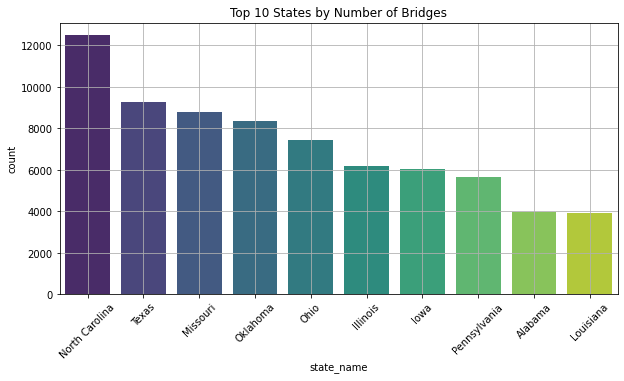

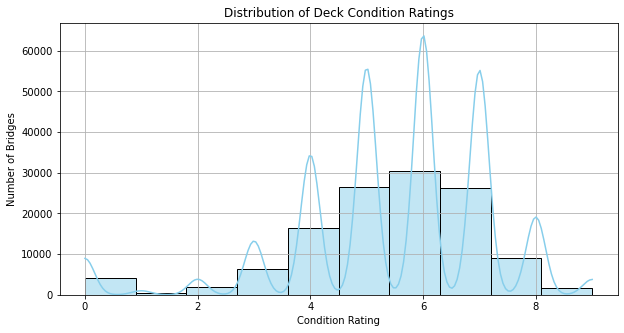

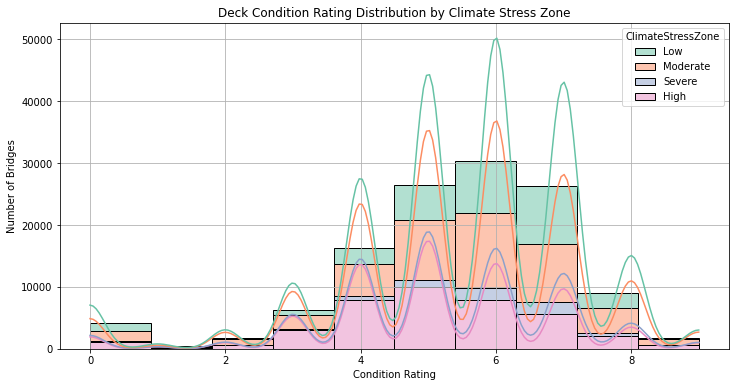

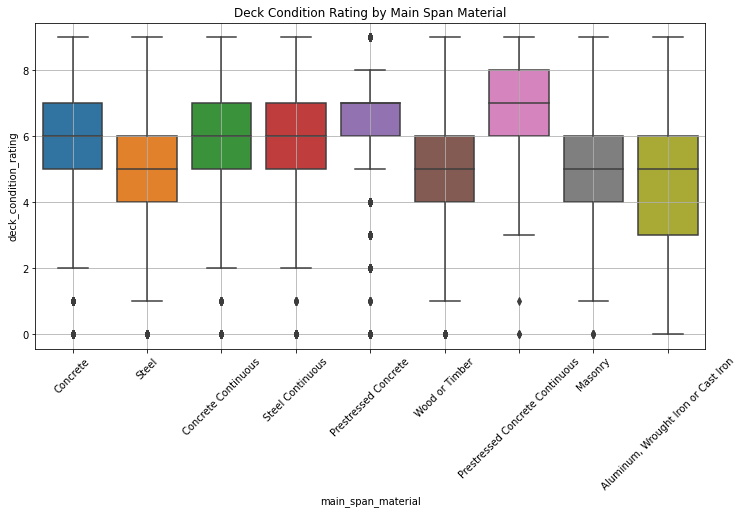

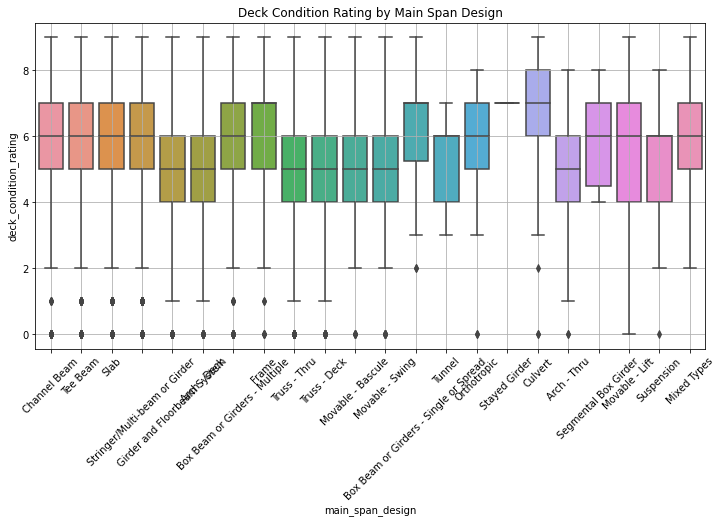

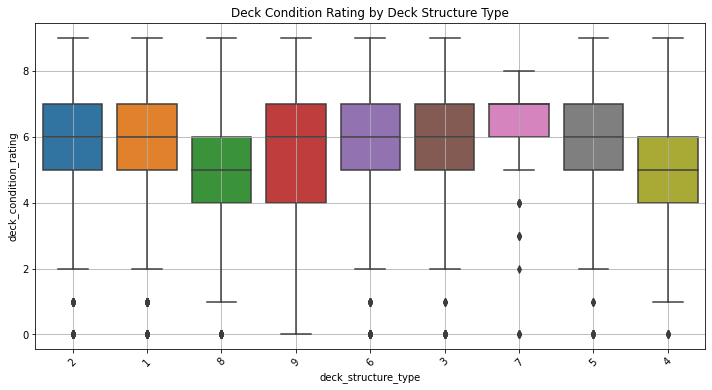

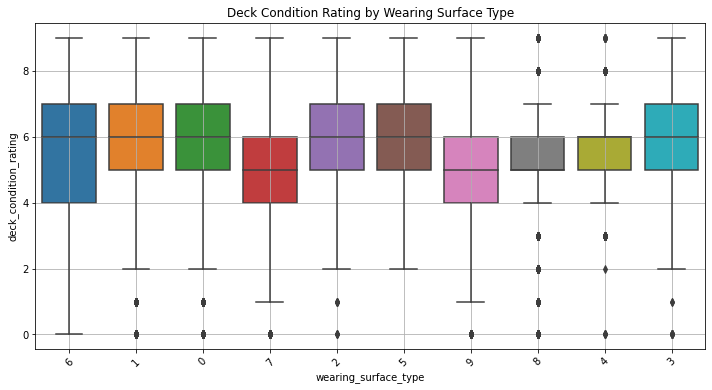

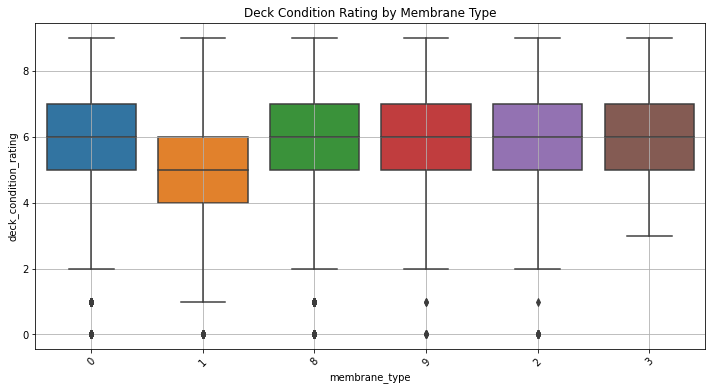

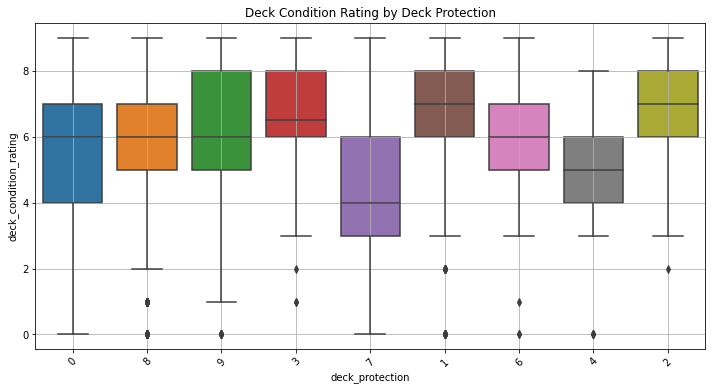

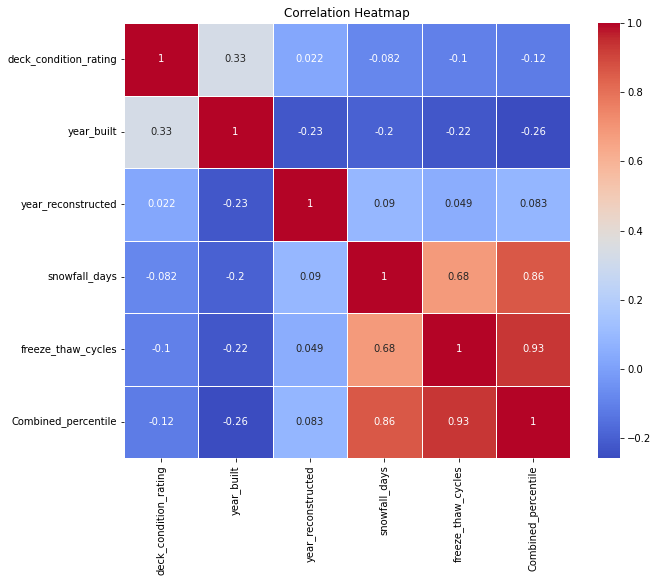

In [0]:
# Top 10 States by Bridge Count
top_states = dataframe_pd['state_name'].value_counts().nlargest(10).index
plt.figure(figsize=(10,5))
sns.countplot(data=dataframe_pd[dataframe_pd['state_name'].isin(top_states)], x='state_name', order=top_states, palette='viridis')
plt.title('Top 10 States by Number of Bridges')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Deck Condition Rating Distribution
plt.figure(figsize=(10,5))
sns.histplot(dataframe_pd['deck_condition_rating'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Deck Condition Ratings')
plt.xlabel('Condition Rating')
plt.ylabel('Number of Bridges')
plt.grid(True)
plt.show()
# Deck Condition Rating Distribution by Climate Stress Zone
plt.figure(figsize=(12, 6))
sns.histplot(
    data=dataframe_pd, 
    x='deck_condition_rating', 
    bins=10, 
    kde=True, 
    hue='ClimateStressZone', 
    multiple='stack',  # or 'dodge' for side-by-side
    palette='Set2'
)
plt.title('Deck Condition Rating Distribution by Climate Stress Zone')
plt.xlabel('Condition Rating')
plt.ylabel('Number of Bridges')
plt.grid(True)
plt.show()
# Boxplot-Rating by Main Span Material
plt.figure(figsize=(12,6))
sns.boxplot(x='main_span_material', y='deck_condition_rating', data=dataframe_pd)
plt.title('Deck Condition Rating by Main Span Material')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Boxplot-Rating by Main Span Design
plt.figure(figsize=(12,6))
sns.boxplot(x='main_span_design', y='deck_condition_rating', data=dataframe_pd)
plt.title('Deck Condition Rating by Main Span Design')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Boxplot-Rating by Deck Structure Type
plt.figure(figsize=(12,6))
sns.boxplot(x='deck_structure_type', y='deck_condition_rating', data=dataframe_pd)
plt.title('Deck Condition Rating by Deck Structure Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Boxplot-Rating by Wearing Surface Type
plt.figure(figsize=(12,6))
sns.boxplot(x='wearing_surface_type', y='deck_condition_rating', data=dataframe_pd)
plt.title('Deck Condition Rating by Wearing Surface Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Boxplot-Rating by Membrane Type
plt.figure(figsize=(12,6))
sns.boxplot(x='membrane_type', y='deck_condition_rating', data=dataframe_pd)
plt.title('Deck Condition Rating by Membrane Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Boxplot-Rating by Deck Protection
plt.figure(figsize=(12,6))
sns.boxplot(x='deck_protection', y='deck_condition_rating', data=dataframe_pd)
plt.title('Deck Condition Rating by Deck Protection')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Heatmap-Correlation Matrix
plt.figure(figsize=(10,8))
corr_cols = ['deck_condition_rating', 'year_built', 'year_reconstructed', 'snowfall_days', 'freeze_thaw_cycles', 'Combined_percentile']
sns.heatmap(dataframe_pd[corr_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

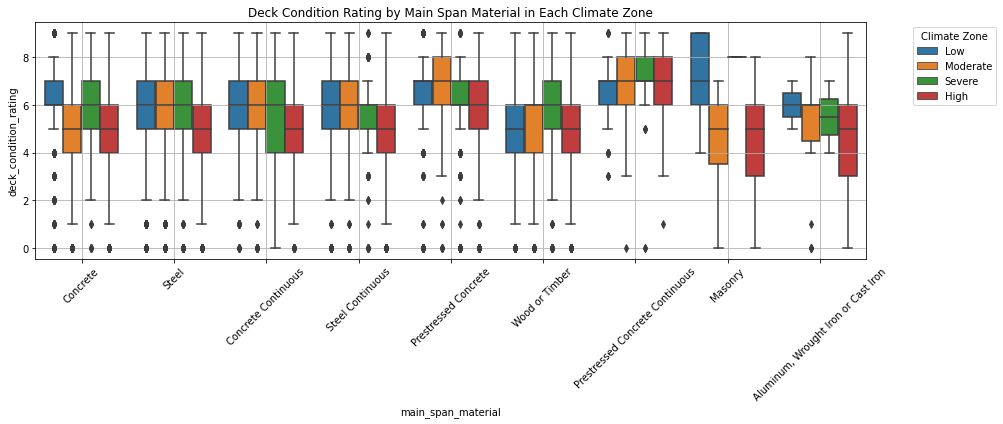

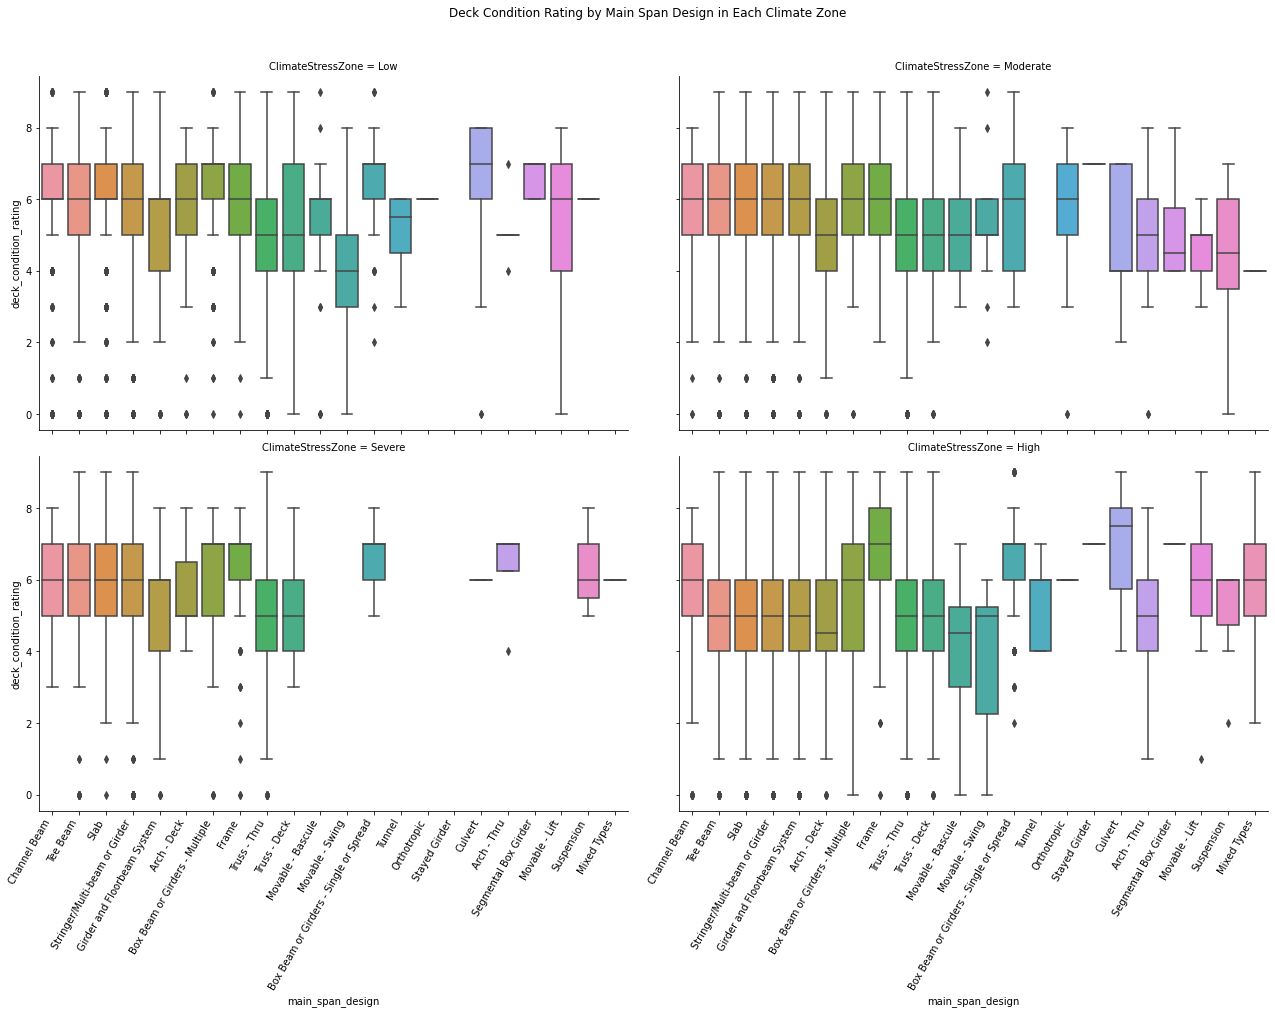

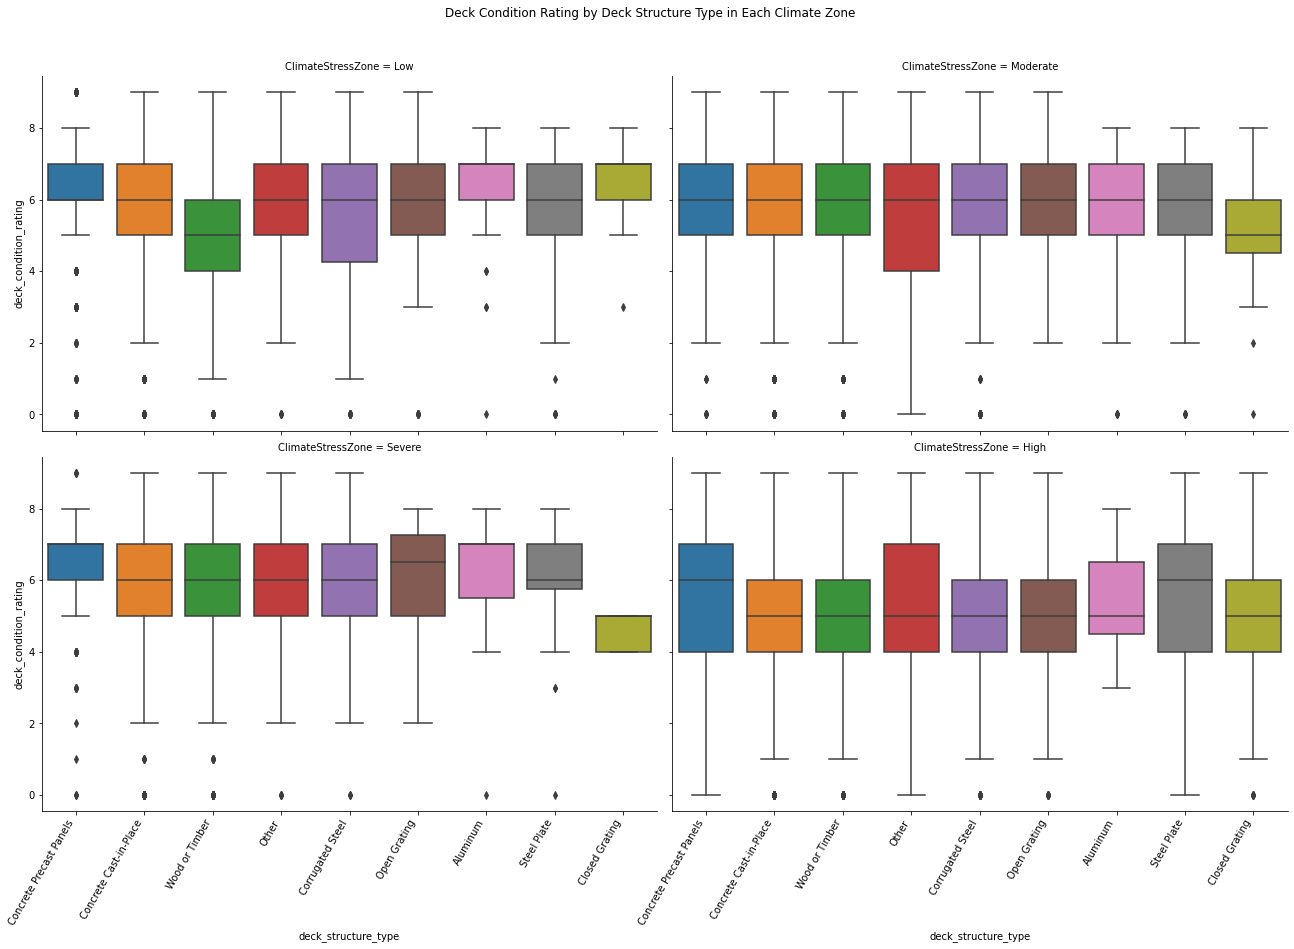

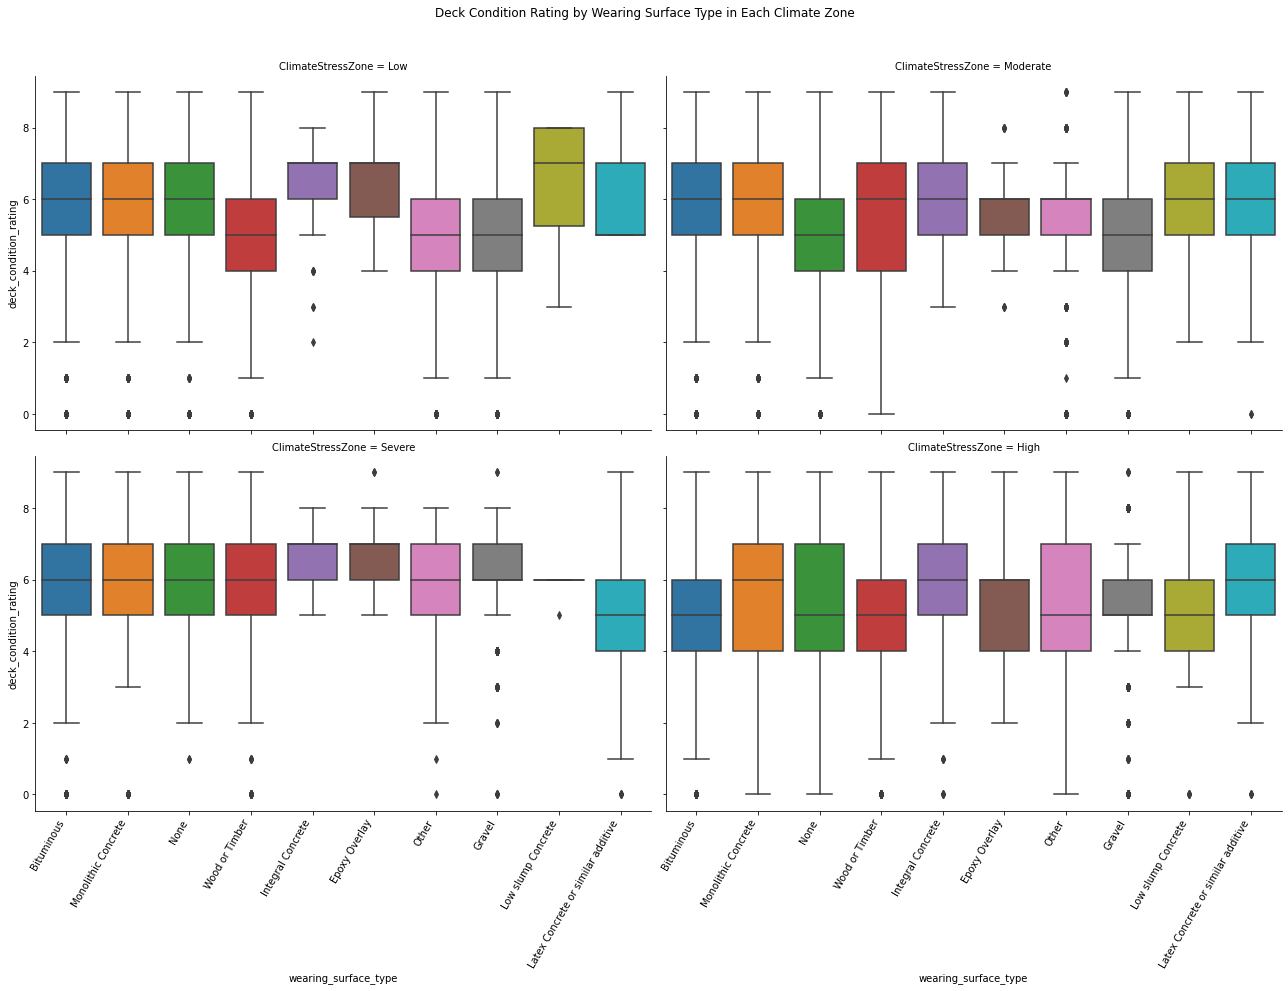

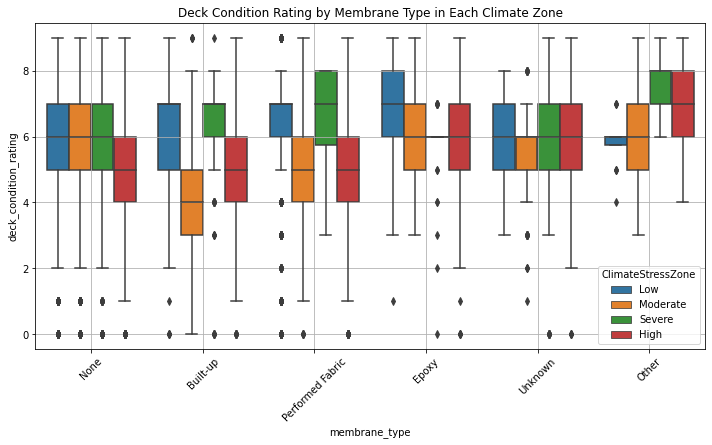

Out[11]: Text(0.5, 0.98, 'Deck Condition Rating by Deck Protection in Each Climate Zone')

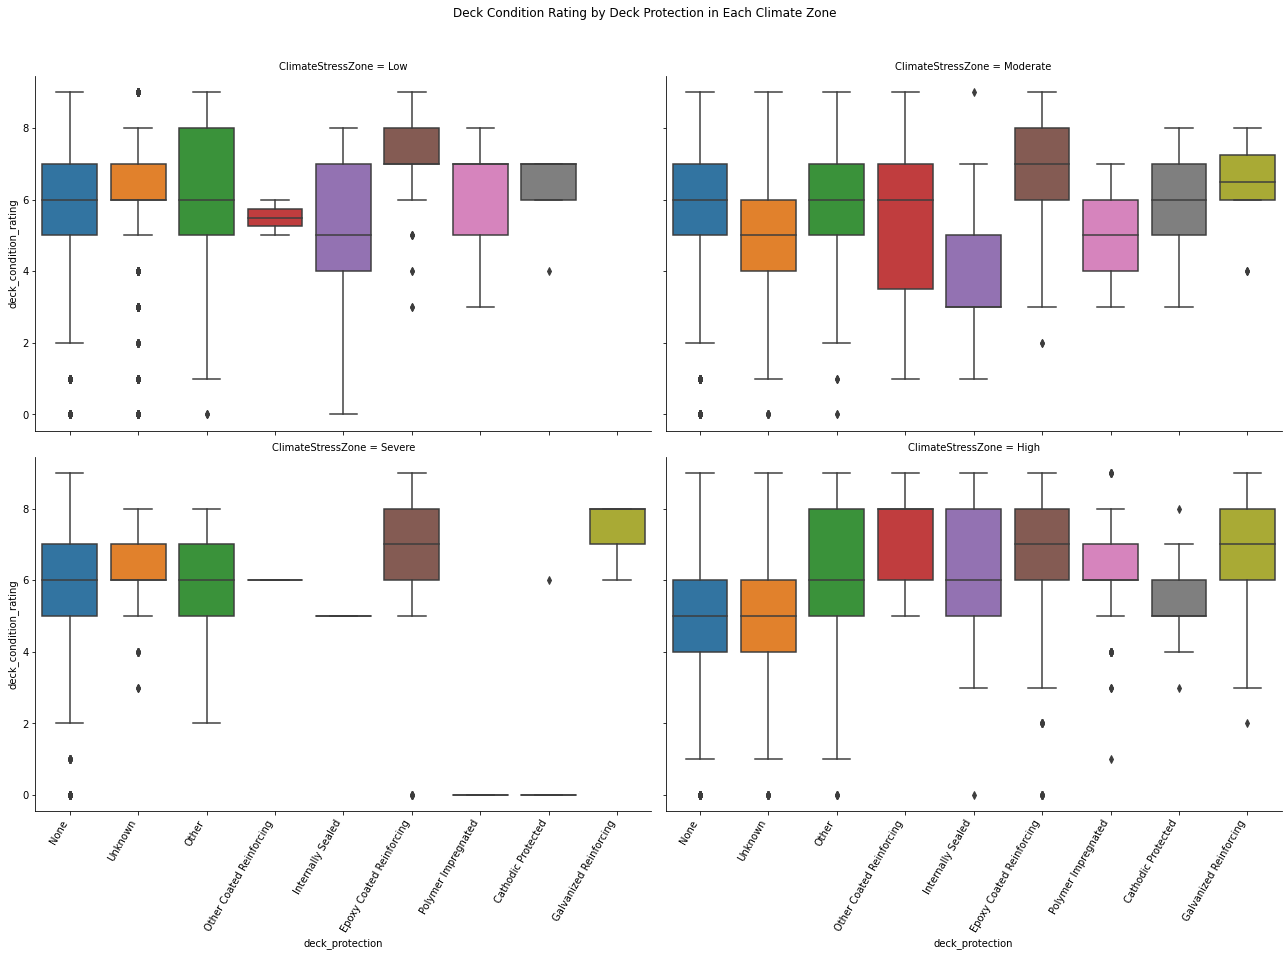

In [0]:
# Boxplot-Rating by Main Span Material per Climate Zone
plt.figure(figsize=(14,6))
sns.boxplot(x='main_span_material', y='deck_condition_rating', hue='ClimateStressZone', data=dataframe_pd)
plt.title('Deck Condition Rating by Main Span Material in Each Climate Zone')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Climate Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
# Boxplot-Rating by Main Span Design per Climate Zone
g = sns.catplot(
    data=dataframe_pd,
    x='main_span_design',
    y='deck_condition_rating',
    col='ClimateStressZone',
    kind='box',
    height=6,
    aspect=1.5,
    col_wrap=2
)
g.set_xticklabels(rotation=60, ha='right')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Deck Condition Rating by Main Span Design in Each Climate Zone')
# Boxplot-Rating by Deck Structure Type per Climate Zone
deck_structure_mapping = {
    1: 'Concrete Cast-in-Place',
    2: 'Concrete Precast Panels',
    3: 'Open Grating',
    4: 'Closed Grating',
    5: 'Steel Plate',
    6: 'Corrugated Steel',
    7: 'Aluminum',
    8: 'Wood or Timber',
    9: 'Other'
}
g = sns.catplot(
    data=dataframe_pd,
    x='deck_structure_type',
    y='deck_condition_rating',
    col='ClimateStressZone',
    kind='box',
    height=6,
    aspect=1.5,
    col_wrap=2
)
for ax in g.axes.flat:
    ax.set_xticklabels([deck_structure_mapping.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], rotation=60, ha='right')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Deck Condition Rating by Deck Structure Type in Each Climate Zone')
# Boxplot-Rating by Wearing Surface Type per Climate Zone
wearing_surface_mapping = {
    0: 'None',
    1: 'Monolithic Concrete',
    2: 'Integral Concrete',
    3: 'Latex Concrete or similar additive',
    4: 'Low slump Concrete',
    5: 'Epoxy Overlay',
    6: 'Bituminous',
    7: 'Wood or Timber',
    8: 'Gravel',
    9: 'Other'
}
g = sns.catplot(
    data=dataframe_pd,
    x='wearing_surface_type',
    y='deck_condition_rating',
    col='ClimateStressZone',
    kind='box',
    height=6,
    aspect=1.5,
    col_wrap=2
)
for ax in g.axes.flat:
    ax.set_xticklabels([wearing_surface_mapping.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], rotation=60, ha='right')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Deck Condition Rating by Wearing Surface Type in Each Climate Zone')

# Boxplot-Rating by Membrane Type per Climzte Zone
membrane_mapping = {
    0: 'None',
    1: 'Built-up',
    2: 'Performed Fabric',
    3: 'Epoxy',
    4: 'Unknown',
    5: 'Other'
}
plt.figure(figsize=(12,6))
sns.boxplot(x='membrane_type', y='deck_condition_rating', hue='ClimateStressZone', data=dataframe_pd)
plt.title('Deck Condition Rating by Membrane Type in Each Climate Zone')
plt.xticks(
    ticks=range(len(membrane_mapping)), 
    labels=[membrane_mapping.get(i, str(i)) for i in range(len(membrane_mapping))],
    rotation=45
)
plt.grid(True)
plt.show()
# Boxplot-Rating by Deck Protection per Climate Zone
deck_protection_mapping = {
    0: 'None',
    1: 'Epoxy Coated Reinforcing',
    2: 'Galvanized Reinforcing',
    3: 'Other Coated Reinforcing',
    4: 'Cathodic Protected',
    6: 'Polymer Impregnated',
    7: 'Internally Sealed',
    8: 'Unknown',
    9: 'Other'
}
g = sns.catplot(
    data=dataframe_pd,
    x='deck_protection',
    y='deck_condition_rating',
    col='ClimateStressZone',
    kind='box',
    height=6,
    aspect=1.5,
    col_wrap=2
)
for ax in g.axes.flat:
    ax.set_xticklabels([deck_protection_mapping.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], rotation=60, ha='right')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Deck Condition Rating by Deck Protection in Each Climate Zone')

In [0]:
# Export Cleaned Dataset
local_tmp_path = "/tmp/selected_bridge_cleaned_dataset.csv"
dbfs_path = "dbfs:/FileStore/tables/selected_bridge_cleaned_dataset.csv"
# Delete if file already exists
if any(f.name == "selected_bridge_cleaned_dataset.csv" for f in dbutils.fs.ls("dbfs:/FileStore/tables/")):
    dbutils.fs.rm(dbfs_path)
dataframe_pd.to_csv(local_tmp_path, index=False)
dbutils.fs.cp(f"file:{local_tmp_path}", dbfs_path)
print("Cleaned dataset saved to:", dbfs_path)

Cleaned dataset saved to: dbfs:/FileStore/tables/selected_bridge_cleaned_dataset.csv


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
import xgboost as xgb
# Allow plots inline
%matplotlib inline

In [0]:
file_path = "dbfs:/FileStore/tables/selected_bridge_cleaned_dataset.csv"
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

In [0]:
df = df_spark.toPandas()
df.head()

,state_code,state_name,structure_number,owner_agency,main_span_material,main_span_design,deck_structure_type,wearing_surface_type,membrane_type,deck_protection,deck_condition_rating,snowfall_days,freeze_thaw_cycles,year_built,year_reconstructed,SnowfallDays_percentile,FreezeThaw_percentile,Combined_percentile,ClimateStressZone
0,1,Alabama,012218,State Highway Agency,Concrete,Channel Beam,2,6,0,0,4.0,0,10,1979,0.0,0.029086,0.063110,0.046098,Low
1,1,Alabama,000529,State Highway Agency,Concrete,Tee Beam,1,6,0,0,4.0,1,33,1928,0.0,0.069682,0.164588,0.117135,Low
2,1,Alabama,007580,County Highway Agency,Concrete,Slab,1,1,0,8,5.0,2,25,1962,0.0,0.093642,0.128008,0.110825,Low
3,1,Alabama,005787,County Highway Agency,Concrete,Slab,1,1,0,0,8.0,0,9,1957,1993.0,0.029086,0.059265,0.044175,Low
4,1,Alabama,012021,City or Municipal Highway Agency,Concrete,Tee Beam,2,1,0,0,6.0,4,52,1978,0.0,0.141701,0.269684,0.205693,Low


In [0]:
# Define a function to assign climate zones based on percentiles
def assign_climate_zone(snow_pct, ftc_pct):
    if snow_pct >= 0.75 and ftc_pct >= 0.75:
        return "cold"
    elif snow_pct <= 0.25 and ftc_pct <= 0.25:
        return "hot"
    elif 0.25 < snow_pct < 0.75 and ftc_pct >= 0.75:
        return "rainy"
    elif snow_pct >= 0.5 and ftc_pct < 0.25:
        return "dry-cold"
    else:
        return "moderate"
# Apply to each row
df["Climate Zone"] = df.apply(
    lambda row: assign_climate_zone(row["SnowfallDays_percentile"], row["FreezeThaw_percentile"]),
    axis=1
)

#### Categorize the Labels

In [0]:
# Material from main_span_material
df['Material'] = df['main_span_material'].fillna('unknown').str.lower()
df['Material'] = df['Material'].apply(lambda x: 'Concrete' if 'concrete' in x else 
                                                'Steel' if 'steel' in x else 
                                                'Wood' if 'wood' in x else 'Other')

In [0]:
design_category_mapping = {
    'Arch': ['Arch - Deck', 'Arch - Thru'],
    'Beam': ['Box Beam or Girders - Multiple', 'Box Beam or Girders - Single or Spread', 'Channel Beam', 'Tee Beam'],
    'Culvert': ['Culvert'],
    'Frame': ['Frame'],
    'Girder': ['Girder and Floorbeam System', 'Stringer/Multi-beam or Girder', 'Segmental Box Girder', 'Stayed Girder'],
    'Movable': ['Movable - Bascule', 'Movable - Lift', 'Movable - Swing'],
    'Truss': ['Truss - Deck', 'Truss - Thru'],
    'Suspension': ['Suspension'],
    'Tunnel': ['Tunnel'],
    'Mixed': ['Mixed Types'],
    'Other': ['Orthotropic', 'Slab']
}
# Inverse map to assign categories to each bridge type
bridge_to_category = {}
for category, designs in design_category_mapping.items():
    for design in designs:
        bridge_to_category[design] = category
df['Design'] = df['main_span_design'].fillna('unknown')
df['Design'] = df['Design'].map(bridge_to_category)

In [0]:
# Convert Columns to String (incase they are not string)
cols_to_convert = ["deck_structure_type", "wearing_surface_type", "membrane_type", "deck_protection"]
for col in cols_to_convert:
    df[col] = df[col].apply(lambda x: str(int(x)) if pd.notnull(x) else x)

In [0]:
deck_structure_category_mapping = {
    '1': 'Concrete',
    '2': 'Concrete',
    '3': 'Grating',
    '4': 'Grating',
    '5': 'Steel',
    '6': 'Steel',
    '7': 'Metal',
    '8': 'Wood',
    '9': 'Other'
}
# Deck Structure from deck_structure_type
df['Deck Structure'] = df['deck_structure_type'].fillna('unknown')
df['Deck Structure'] = df['Deck Structure'].map(deck_structure_category_mapping)

In [0]:
wearing_surface_category_mapping = {
    '0': 'None',
    '1': 'Concrete',
    '2': 'Concrete',
    '3': 'Concrete',
    '4': 'Concrete',
    '5': 'Overlay',
    '6': 'Bituminous',
    '7': 'Wood',
    '8': 'Gravel',
    '9': 'Other'
}
# Wearing Surface from wearing_surface_type
df['Wearing Surface'] = df['wearing_surface_type'].fillna('unknown')
df['Wearing Surface'] = df['Wearing Surface'].map(wearing_surface_category_mapping)

In [0]:
membrane_category_mapping = {
    '0': 'None',
    '1': 'Built-up',
    '2': 'Performed Fabric',
    '3': 'Epoxy',
    '8': 'Unknown',
    '9': 'Other'
}
# Membrane from membrane_type
df['Membrane'] = df['membrane_type'].fillna('unknown')
df['Membrane'] = df['membrane_type'].map(membrane_category_mapping)

In [0]:
deck_protection_category_mapping = {
    '0': 'None',
    '1': 'Coated Reinforcing',
    '2': 'Coated Reinforcing',
    '3': 'Coated Reinforcing',
    '4': 'Special Protection',
    '6': 'Special Protection',
    '7': 'Special Protection',
    '8': 'Unknown/Other',
    '9': 'Unknown/Other'
}
# Protection from deck_protection
df['Protection'] = df['deck_protection'].fillna('unknown')
df['Protection'] = df['Protection'].map(deck_protection_category_mapping)


In [0]:
# Verify labels
print(sorted(df['Material'].unique()))
print(sorted(df['Design'].unique()))
print(sorted(df['Deck Structure'].unique()))
print(sorted(df['Wearing Surface'].unique()))
print(sorted(df['Membrane'].unique()))
print(sorted(df['Protection'].unique()))


['Concrete', 'Other', 'Steel', 'Wood']
['Arch', 'Beam', 'Culvert', 'Frame', 'Girder', 'Mixed', 'Movable', 'Other', 'Suspension', 'Truss', 'Tunnel']
['Concrete', 'Grating', 'Metal', 'Other', 'Steel', 'Wood']
['Bituminous', 'Concrete', 'Gravel', 'None', 'Other', 'Overlay', 'Wood']
['Built-up', 'Epoxy', 'None', 'Other', 'Performed Fabric', 'Unknown']
['Coated Reinforcing', 'None', 'Special Protection', 'Unknown/Other']


In [0]:
df.head()

,state_code,state_name,structure_number,owner_agency,main_span_material,main_span_design,deck_structure_type,wearing_surface_type,membrane_type,deck_protection,...,FreezeThaw_percentile,Combined_percentile,ClimateStressZone,Climate Zone,Material,Design,Deck Structure,Wearing Surface,Membrane,Protection
0,1,Alabama,012218,State Highway Agency,Concrete,Channel Beam,2,6,0,0,...,0.063110,0.046098,Low,hot,Concrete,Beam,Concrete,Bituminous,None,None
1,1,Alabama,000529,State Highway Agency,Concrete,Tee Beam,1,6,0,0,...,0.164588,0.117135,Low,hot,Concrete,Beam,Concrete,Bituminous,None,None
2,1,Alabama,007580,County Highway Agency,Concrete,Slab,1,1,0,8,...,0.128008,0.110825,Low,hot,Concrete,Other,Concrete,Concrete,None,Unknown/Other
3,1,Alabama,005787,County Highway Agency,Concrete,Slab,1,1,0,0,...,0.059265,0.044175,Low,hot,Concrete,Other,Concrete,Concrete,None,None
4,1,Alabama,012021,City or Municipal Highway Agency,Concrete,Tee Beam,2,1,0,0,...,0.269684,0.205693,Low,moderate,Concrete,Beam,Concrete,Concrete,None,None


#### ML Model

In [0]:
df_model = df.copy()
# Encode categorical columns
categorical = ['state_name', 'owner_agency', 'main_span_material',
               'main_span_design', 'deck_structure_type', 'wearing_surface_type', 'ClimateStressZone', 'Climate Zone', 'Material', 'Design', 'Deck Structure', 'Wearing Surface', 'Membrane', 'Protection']
df_model[categorical] = df_model[categorical].fillna("Unknown")
for col in categorical:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
# Impute numeric
num_cols = df_model.select_dtypes(include=[np.number]).columns
df_model[num_cols] = SimpleImputer(strategy='median').fit_transform(df_model[num_cols])

              precision    recall  f1-score   support

    Not Good       0.84      0.88      0.86     17187
        Good       0.69      0.62      0.66      7417

    accuracy                           0.80     24604
   macro avg       0.77      0.75      0.76     24604
weighted avg       0.80      0.80      0.80     24604



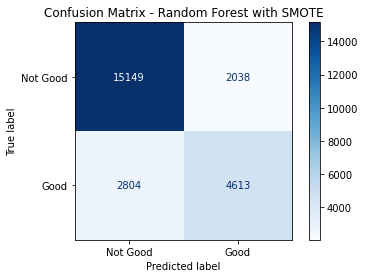

In [0]:
from imblearn.over_sampling import SMOTE
X = df_model.drop(columns=['deck_condition_rating', 'structure_number', 'SnowfallDays_percentile', 'FreezeThaw_percentile', 'Combined_percentile', 'main_span_material', 'main_span_design', 'deck_structure_type', 'wearing_surface_type', 'membrane_type', 'deck_protection'])
y = df_model['deck_condition_rating'].astype(int)
y_binary = (y >= 7).astype(int)
# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, stratify=y_binary, random_state=42)
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
# Train Random Forest
rf = RandomForestClassifier(n_estimators=150, max_depth=20, random_state=42)
rf.fit(X_train_scaled, y_train_smote)
rf_preds = rf.predict(X_test_scaled)
# Evaluate
print(classification_report(y_test, rf_preds, target_names=["Not Good", "Good"]))
cm = confusion_matrix(y_test, rf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Good", "Good"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest with SMOTE")
plt.show()

=== Lasso Classification Report ===
              precision    recall  f1-score   support

    Not Good       0.83      0.67      0.74     17187
        Good       0.47      0.69      0.56      7417

    accuracy                           0.67     24604
   macro avg       0.65      0.68      0.65     24604
weighted avg       0.72      0.67      0.69     24604



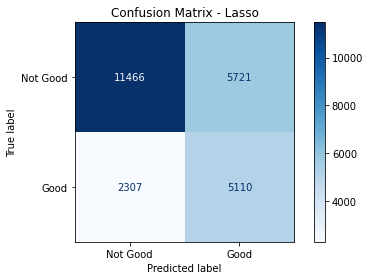

In [0]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train_smote)
# Predict and round
lasso_preds = np.round(lasso.predict(X_test_scaled)).astype(int)
# Evaluation
print("=== Lasso Classification Report ===")
print(classification_report(y_test, lasso_preds, target_names=["Not Good", "Good"]))
# Confusion Matrix
cm = confusion_matrix(y_test, lasso_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Good", "Good"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Lasso")
plt.tight_layout()
plt.show()

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

    Not Good       0.83      0.87      0.85     17187
        Good       0.67      0.60      0.63      7417

    accuracy                           0.79     24604
   macro avg       0.75      0.74      0.74     24604
weighted avg       0.78      0.79      0.79     24604



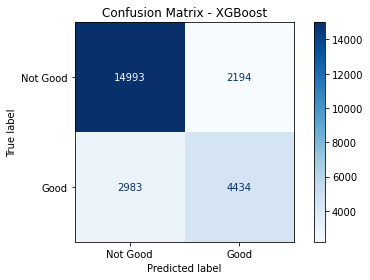

In [0]:
# Train XGBoost Classifier
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_scaled, y_train_smote)
# Predict
xgb_preds = xgb_clf.predict(X_test_scaled)
# Report
print("=== XGBoost Classification Report ===")
print(classification_report(y_test, xgb_preds, target_names=["Not Good", "Good"]))
# Confusion Matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Good", "Good"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()

In [0]:
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
# Calculate F1-score and Accuracy for each model
metrics = {
    "Model": ["Random Forest", "Lasso", "XGBoost"],
    "F1 Score": [
        f1_score(y_test, rf_preds),
        f1_score(y_test, lasso_preds),
        f1_score(y_test, xgb_preds)
    ],
    "Accuracy": [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, lasso_preds),
        accuracy_score(y_test, xgb_preds)
    ]
}
# Create and print 
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

           Model  F1 Score  Accuracy
0  Random Forest  0.655815  0.803203
1          Lasso  0.560061  0.673712
2        XGBoost  0.631399  0.789587


In [0]:
# Balance the classes, split the data, and scale the features
min_count = y.value_counts().min()
df_bal = pd.concat([X, y], axis=1).groupby('deck_condition_rating').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
X_bal = df_bal.drop(columns=['deck_condition_rating'])
y_bal = df_bal['deck_condition_rating']
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

=== Random Forest Regressor Evaluation on Balanced Data ===
Root Mean Squared Error (RMSE): 0.831
R² Score: 0.916


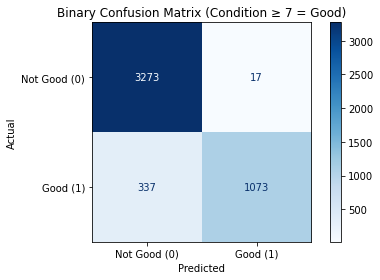

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
# Scale the features
scaler = StandardScaler()
X_bal_scaled = scaler.fit_transform(X_bal)
# Train the Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42)
rf_reg.fit(X_bal_scaled, y_bal)
# Predict
rf_reg_preds = rf_reg.predict(X_bal_scaled)
# Evaluation (regression)
rmse = np.sqrt(mean_squared_error(y_bal, rf_reg_preds))
r2 = r2_score(y_bal, rf_reg_preds)
print("=== Random Forest Regressor Evaluation on Balanced Data ===")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")
# Convert actual and predicted values to binary
threshold = 7
y_true_binary = (y_bal >= threshold).astype(int)
y_pred_binary = (np.round(rf_reg_preds) >= threshold).astype(int)
# Confusion matrix for binary classification
cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=["Not Good (0)", "Good (1)"])
disp.plot(cmap='Blues')
plt.title("Binary Confusion Matrix (Condition ≥ 7 = Good)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()